# Download & Install the packages

In [ ]:
%%capture
!git clone https://github.com/jacons/ilmart
!git clone --recurse-submodules https://github.com/veneres/LightGBM.git
!pip install rankeval
%cd LightGBM/python-package
!python setup.py install
%cd ../../ilmart
!pip install -e .
%cd ../ilmart

In [ ]:
import sys
import pandas as pd
import numpy as np

from tqdm import tqdm
from typing import Tuple
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import ndcg_score
from src.ilmart import Ilmart, IlmartDistill, utils
import lightgbm as lgbm

import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2

# Grid search implementation

In [ ]:
class ILMARTGridsearch:
  def __init__(self, train: str, valid: str, test: str, nDCG_at: int):

    train, valid, test = pd.read_csv(train), pd.read_csv(valid), pd.read_csv(test)

    # sorting after the splitting
    self.train = train.sort_values(["qId", "kId"])
    self.valid = valid.sort_values(["qId", "kId"])
    self.test = test.sort_values(["qId", "kId"])

    # Preparing the datasets
    self.qIds_train = self.train.groupby("qId")["qId"].count().to_numpy()
    self.X_train, self.y_train = self.train.iloc[:, 2:13], self.train[["qId", "kId", "labels"]]
    self.qIds_val = self.valid.groupby("qId")["qId"].count().to_numpy()
    self.X_valid, self.y_valid = self.valid.iloc[:, 2:13], self.valid[["qId", "kId", "labels"]]
    self.qIds_test = self.test.groupby("qId")["qId"].count().to_numpy()
    self.X_test, self.y_test = self.test.iloc[:, 2:13], self.test[["qId", "kId", "labels"]]

    self.default_par = dict(
      objective="lambdarank",
      boosting_type="gbdt",
      metric="ndcg",
      force_row_wise=True,
      n_jobs=-1,
      verbose = -1
    )
    self.ranker_par = dict(  # default ranker parameters (used in fitting) pt.2
      X_train=self.X_train.to_numpy(),
      y_train=self.y_train["labels"].to_numpy(),
      group_train=self.qIds_train,
      X_valid = self.X_valid.to_numpy(),
      y_valid = self.y_valid["labels"].to_numpy(),
      group_valid=self.qIds_val,
    )

    self.nDCG_at = nDCG_at
    return

  def eval_model(self, model, df: pd.DataFrame = None,
                 qIds: np.ndarray = None, nDCG_at: list = None) -> dict:
      """
      Custom evaluation function: the function groups by the "job-offers" and foreach set, it predicts
      the "lambdas" that it uses to sort (by relevance).
      After obtained nDCGs apply the average.
      """
      df = self.valid if df is None else df
      n_qIds = len(self.qIds_val) if qIds is None else len(qIds)
      nDCG_at = [self.nDCG_at] if nDCG_at is None else nDCG_at
      avg_nDCG = np.zeros((len(nDCG_at)))

      for _, v in df.groupby("qId"):
          v = v.sort_values("labels", ascending=False)

          features, target = v.iloc[:, 2:13].to_numpy(), np.asarray([v["labels"].to_numpy()])
          lambdas = np.asarray([model.get_model().predict(features)])  # predict lambdas

          # Perform the nDCG for a specific job-offer and then sum it into cumulative nDCG
          for i, nDCG in enumerate(nDCG_at):
              avg_nDCG[i] += ndcg_score(target, lambdas, k=nDCG)

      # dived by the number of jobs-offer to obtain the average.
      avg_nDCG /= n_qIds
      results = {"nDCG@"+str(nDCG): round(avg_nDCG[i], 4) for i, nDCG in enumerate(nDCG_at)}
      return results

  def fit(self, **conf):

      model = Ilmart(verbose=False)
      all_params = { **self.default_par, **conf}
      model.fit(all_params,**self.ranker_par)
      return model

  def grid_search(self, hyperparameters: dict = None) -> Tuple:
      # keep the current: (best_model, best_params, best nDCG)
      best_model_: Tuple = (None, None, -sys.maxsize)

      # explore all possible combinations of hyperparameters
      progress_bar = tqdm(ParameterGrid(hyperparameters))
      for conf in progress_bar:
          model = self.fit(**conf)
          avg_nDCG = self.eval_model(model)["nDCG@"+str(self.nDCG_at)]

          # if the model is better respect to the previous one, it updates the tuple
          if avg_nDCG > best_model_[2]:
              best_model_ = (model, conf, avg_nDCG)
          progress_bar.set_postfix(nDCG_15=best_model_[2])
      return best_model_

In [ ]:
ilMart_parameter = dict(
    num_leaves=[2, 5, 10, 20, 30, 40],
    max_depth=[-1],
    learning_rate=[0.02, 0.05, 0.08, 0.1, 0.15, 0.2],
    reg_lambda=[0.00005, 0.0001, 0.0002, 0.0003]
)
gridsearch_parameters = dict( # unbalanced sources
    train="https://raw.githubusercontent.com/jacons/ExplainableLtR/master/outputs/scores/scores_tr.csv",
    valid="https://raw.githubusercontent.com/jacons/ExplainableLtR/master/outputs/scores/scores_vl.csv",
    test="https://raw.githubusercontent.com/jacons/ExplainableLtR/master/outputs/scores/scores_ts.csv",
    nDCG_at=15
)
gridsearch_parameters2 = dict( # balanced sources
    train="https://raw.githubusercontent.com/jacons/ExplainableLtR/master/outputs/bal_scores/scores_tr.csv",
    valid="https://raw.githubusercontent.com/jacons/ExplainableLtR/master/outputs/bal_scores/scores_vl.csv",
    test="https://raw.githubusercontent.com/jacons/ExplainableLtR/master/outputs/bal_scores/scores_ts.csv",
    nDCG_at=15
)

In [ ]:
gs = ILMARTGridsearch(**gridsearch_parameters)
best_ = gs.grid_search(ilMart_parameter)

100%|██████████| 144/144 [16:24<00:00,  6.84s/it, nDCG_15=0.855]


In [ ]:
best_

(<src.ilmart.ilmart.Ilmart at 0x7ea7c4f0a500>,
 {'learning_rate': 0.2,
  'max_depth': -1,
  'num_leaves': 5,
  'reg_lambda': 0.0001},
 0.8551)

In [ ]:
# nDCG
nDCG_train = gs.eval_model(model=best_[0], df=gs.train, qIds=gs.qIds_train, nDCG_at=[1,10,15])
nDCG_valid = gs.eval_model(model=best_[0], df=gs.valid, qIds=gs.qIds_val, nDCG_at=[1,10,15])
nDCG_test = gs.eval_model(model=best_[0], df=gs.test, qIds=gs.qIds_test, nDCG_at=[1,10,15])

display(pd.DataFrame([nDCG_train,nDCG_valid,nDCG_test],index=["Training","Validation","Test"]))

,nDCG@1,nDCG@10,nDCG@15
Training,0.9417,0.9242,0.9042
Validation,0.9583,0.8735,0.8551
Test,0.9133,0.8833,0.8643


In [ ]:
best_[0].get_model().save_model("file_name.lgbm")
best_model = lgbm.Booster(model_file="file_name.lgbm")
distilled_best_model = IlmartDistill(best_model)

# Feature importance

In [ ]:
id2feature = {i:v for i,v in enumerate(list(gs.X_train.columns))}

In [ ]:
list_features = list(gs.X_train.columns)
features_importance = best_model.feature_importance()
order_idx = np.argsort(features_importance)
features_importance = features_importance[order_idx]
labels_name = [list_features[i] for i in order_idx]

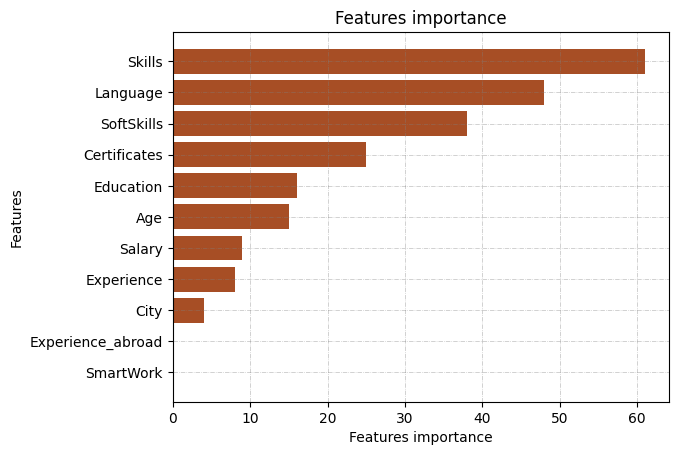

In [ ]:
plt.barh(range(len(features_importance)), features_importance, color="#a74e25")
plt.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
plt.yticks(range(len(features_importance)), labels_name)
plt.title('Features importance')
plt.xlabel('Features importance')
plt.ylabel('Features')
plt.show()

# Explain the model

In [ ]:
def pairwise_function(cuts, contribution, value: float) -> float:
  if value < cuts[0]:
      return contribution[0]
  for i in range(len(cuts)-1):
      if cuts[i] <= value <= cuts[i+1]:
          return contribution[i+1]
  if value > cuts[-1]:
      return contribution[-1]

def explanation(model, index_feature: int, eps: float = 0.01) -> Tuple[np.ndarray, np.ndarray]:

  min_, max_ = gs.X_train.iloc[:,index_feature].min(), gs.X_train.iloc[:,index_feature].max()
  cuts = model.splitting_values[index_feature][1:-1]
  contrib = model.hist[(index_feature,)]
  x = np.arange(min_, max_, eps)
  y = [pairwise_function(cuts, contrib, v_) for v_ in x]
  return x, y

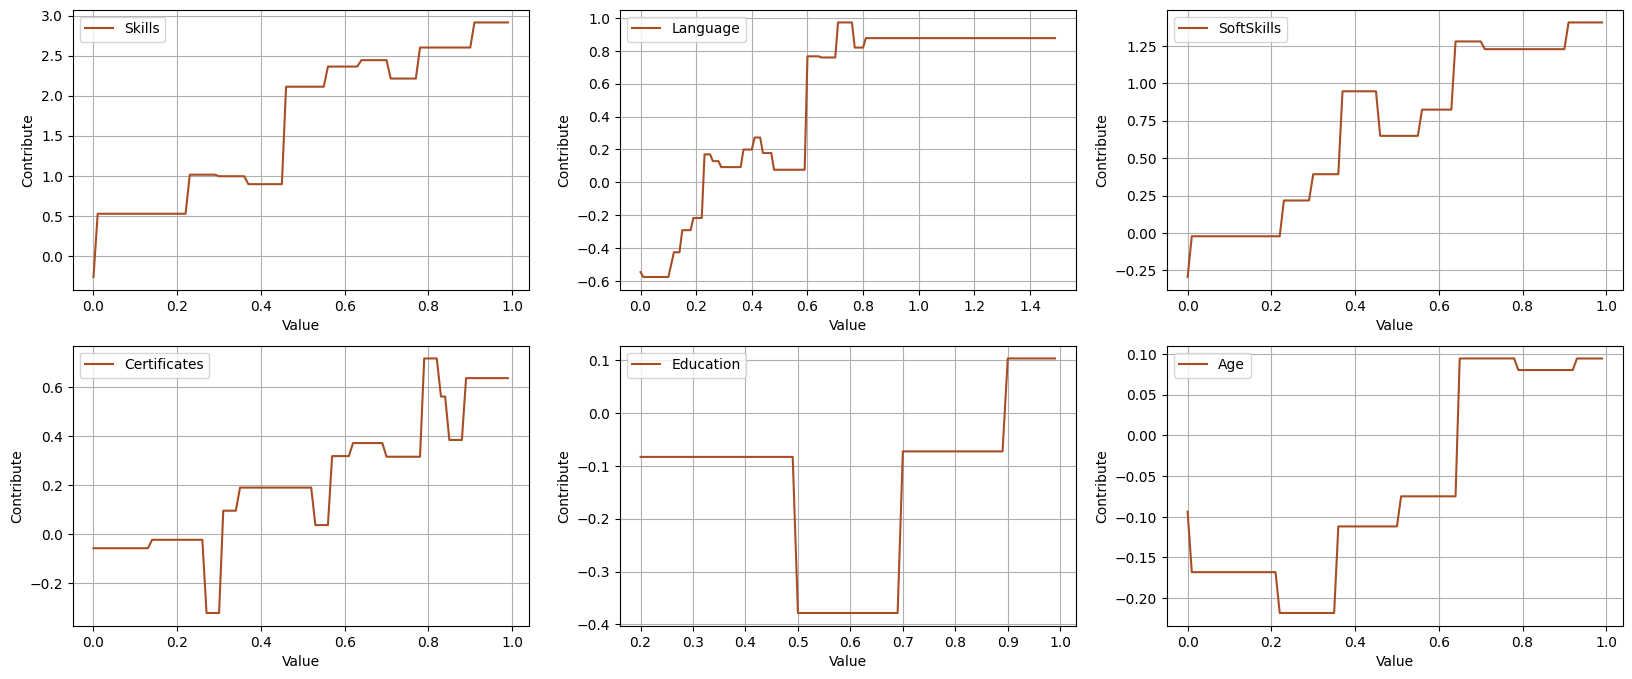

In [ ]:
f, axs = plt.subplots(ncols=3,nrows=2,figsize=(20,8))

for i, feature in enumerate(order_idx[::-1][:6]):

    x,y = explanation(distilled_best_model, feature)
    axs[int(i/3)][i%3].set_xlabel("Value")
    axs[int(i/3)][i%3].set_ylabel("Contribute")
    axs[int(i/3)][i%3].grid()
    axs[int(i/3)][i%3].plot(x,y, label=id2feature[feature], color="#a74e25")
    axs[int(i/3)][i%3].legend()
plt.show()

In [ ]:
gs.test[gs.test["qId"]==15][["kId","labels"]].sort_values("labels",ascending=False).head(15)

,kId,labels
171,256,3
4808,117,3
2839,228,3
3583,101,2
4227,87,2
1459,200,2
2043,251,2
1433,249,2
1483,105,2
4905,109,2


In [ ]:
features = gs.test[gs.test["qId"]==15]
y_pred = best_model.predict(np.asarray(features.iloc[:,2:13].values))
y_pred = pd.DataFrame(y_pred, index=features.index, columns=["lambdas"])
dt_final = pd.merge(features, y_pred, left_index=True, right_index=True)
dt_final.sort_values("lambdas",ascending=False)[["kId","labels"]].head(15)

,kId,labels
171,256,3
2839,228,3
4808,117,3
2307,151,2
902,265,1
2712,194,2
948,77,1
162,260,2
2259,281,2
2635,34,2


# Grid Search Balanced

In [ ]:
gs = ILMARTGridsearch(**gridsearch_parameters2)
best_ = gs.grid_search(ilMart_parameter)

100%|██████████| 144/144 [12:07<00:00,  5.05s/it, nDCG_15=0.874]


In [ ]:
best_

(<src.ilmart.ilmart.Ilmart at 0x7ea78bf41d80>,
 {'learning_rate': 0.2, 'max_depth': -1, 'num_leaves': 2, 'reg_lambda': 5e-05},
 0.8742)

In [ ]:
# nDCG
nDCG_train = gs.eval_model(model=best_[0], df=gs.train, qIds=gs.qIds_train, nDCG_at=[1,10,15])
nDCG_valid = gs.eval_model(model=best_[0], df=gs.valid, qIds=gs.qIds_val, nDCG_at=[1,10,15])
nDCG_test = gs.eval_model(model=best_[0], df=gs.test, qIds=gs.qIds_test, nDCG_at=[1,10,15])

display(pd.DataFrame([nDCG_train,nDCG_valid,nDCG_test],index=["Training","Validation","Test"]))

,nDCG@1,nDCG@10,nDCG@15
Training,0.9450,0.9415,0.9272
Validation,0.9617,0.8914,0.8742
Test,0.9167,0.9092,0.8917
